## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

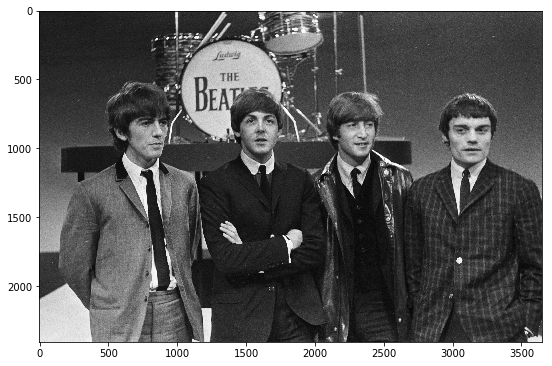

In [90]:
import cv2
# load in color image for face detection
image_1 = cv2.imread('images/obamas.jpg')
image_2 = cv2.imread('images/mona_lisa.jpg')
image_3 = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

images = [image_1, image_2, image_3]

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(images[2])

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


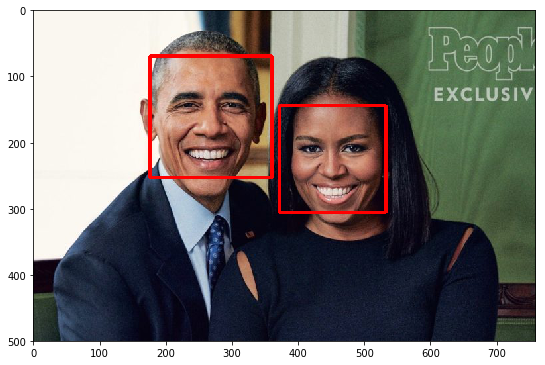

In [111]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces_list = []
images_with_detections = []
# make a copy of the original image to plot detections on
for image in images:
    faces_list.append(face_cascade.detectMultiScale(image, 1.3, 5))
    images_with_detections.append(image.copy())
    

for i, faces in enumerate(faces_list):
    # loop over the detected faces, mark the image where each face is found
    
    rec_thickness = images_with_detections[i].shape[0]//150
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(images_with_detections[i],(x,y),(x+w,y+h),(255,0,0),rec_thickness) 

fig = plt.figure(figsize=(9,9))

plt.imshow(images_with_detections[0])

## Detect mouth, nose and eyes
Detect mouth, nose and eyes in the detected faces.

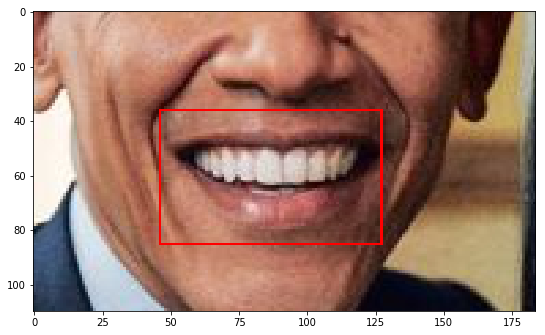

In [151]:
# load in a haar cascade classifier for detecting mouth
# cascade source: https://github.com/peterbraden/node-opencv/tree/master/data
mouth_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_mcs_mouth.xml')

img_nr = 0
scale = 0

image_copy = np.copy(images[img_nr])
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces_list[img_nr]:
    # Select the region of interest that is the face in the image
    y = int((h-y)*1.4)
    h = int(h*0.6)
    roi = image_copy[y-scale:y+h, x-scale:x+w+scale]
    # Convert the face region from RGB to grayscale
    #roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    face = mouth_cascade.detectMultiScale(roi, 1.2, 50)
    image_with_detections = roi.copy()
    
    for (x,y,w,h) in face:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),1) 
        
fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [106]:
import torch
from models import NaimishNet

subs = ['outline','eyebrows','nose', 'eyes', 'mouth', 'face']

hp = {'outline': (128, 34, [5,5,5,5], [8, 16, 32, 64], False) ,
      'eyebrows': (128, 20, [5,5,5,5], [8, 16, 32, 64], False) ,
      'nose': (128, 18, [5,5,5,5], [8, 16, 32, 64], False) ,
      'eyes': (128, 24, [5,5,5,5], [8, 16, 32, 64], False) ,
      'mouth': (128, 40, [5,5,5,5], [32,64,128,256], False) ,
      'face': (128, 136, [5,5,5,5], [8, 16, 32, 64], False) }

outline_net =  NaimishNet(hp[subs[0]][0], output_size = hp[subs[0]][1], kernels = hp[subs[0]][2], out_channels= hp[subs[0]][3], use_maxp=hp[subs[0]][4])
eyebrows_net = NaimishNet(hp[subs[1]][0], output_size = hp[subs[1]][1], kernels = hp[subs[1]][2], out_channels= hp[subs[1]][3], use_maxp=hp[subs[1]][4])
nose_net =     NaimishNet(hp[subs[2]][0], output_size = hp[subs[2]][1], kernels = hp[subs[2]][2], out_channels= hp[subs[2]][3], use_maxp=hp[subs[2]][4])
eyes_net =     NaimishNet(hp[subs[3]][0], output_size = hp[subs[3]][1], kernels = hp[subs[3]][2], out_channels= hp[subs[3]][3], use_maxp=hp[subs[3]][4])
mouth_net =    NaimishNet(hp[subs[4]][0], output_size = hp[subs[4]][1], kernels = hp[subs[4]][2], out_channels= hp[subs[4]][3], use_maxp=hp[subs[4]][4])
face_net =     NaimishNet(hp[subs[5]][0], output_size = hp[subs[5]][1], kernels = hp[subs[5]][2], out_channels= hp[subs[5]][3], use_maxp=hp[subs[5]][4])

models = {'outline':outline_net, 'eyebrows': eyebrows_net, 'nose': nose_net,
          'eyes': eyes_net, 'mouth': mouth_net, 'face': face_net}

model_dir = 'saved_models/'
model_names = ['outline_bs64_img_s128_k[5, 5, 5, 5]_out_ch[8, 16, 32, 64]_dp[0, 0, 0, 0, 0, 0]_maxpFalse_ep65_vloss0.00907.pt',
               'eyebrows_bs64_img_s128_k[5, 5, 5, 5]_out_ch[8, 16, 32, 64]_dp[0, 0, 0, 0, 0, 0]_maxpFalse_ep46_vloss0.00724.pt',
               'nose_bs64_img_s128_k[5, 5, 5, 5]_out_ch[8, 16, 32, 64]_dp[0, 0, 0, 0, 0, 0]_maxpFalse_ep70_vloss0.00522.pt',
               'eyes_bs64_img_s128_k[5, 5, 5, 5]_out_ch[8, 16, 32, 64]_dp[0, 0, 0, 0, 0, 0]_maxpFalse_ep39_vloss0.00660.pt',
               'mouth_bs64_img_s128_k[5, 5, 5, 5]_out_ch[32, 64, 128, 256]_dp[0.2, 0.2, 0.2, 0.2, 0.2, 0.2]_maxpFalse_ep62_vloss0.01480.pt',
               'face_bs64_img_s128_k[5, 5, 5, 5]_out_ch[8, 16, 32, 64]_dp[0, 0, 0, 0, 0, 0]_maxpFalse_ep51_vloss0.00614.pt']

for i, model_name in enumerate(model_names):
    models[subs[i]].load_state_dict(torch.load(model_dir+model_name))
    models[subs[i]].eval()

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [109]:
def detect_keypoints(image_nr, scale):
    fig = plt.figure(figsize=(10,10))
    i = 0
    image_copy = np.copy(images[image_nr])
    # loop over the detected faces from your haar cascade
    for (x,y,w,h) in faces_list[image_nr]:
    
        # Select the region of interest that is the face in the image 
        roi = image_copy[y-scale:y+h+scale, x-scale:x+w+scale]
        
        ## Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi/255.0
        ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        h, w = roi.shape
                
        roi = cv2.resize(roi, (img_size, img_size))
        
        # Make copy for displaying keypoint over
        roi_copy = np.copy(roi)
        
        ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        
        # if image has no grayscale color channel, add one
        if(len(roi.shape) == 2):
            # add that third color dim
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        roi = roi.transpose((2, 0, 1))
        
        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)
        
        roi.unsqueeze_(0)
        ## Make facial keypoint predictions using your loaded, trained network     
        ## perform a forward pass to get the predicted facial keypoints
        
        # forward pass to get net output
        #outline_pts = models['outline'](roi)
        #eyebrows_pts = models['eyebrows'](roi)
        #nose_pts = models['nose'](roi)
        #eyes_pts = models['eyes'](roi)
        mouth_pts = models['face'](roi)
        
        # reshape to batch_size x keypoints x 2 pts
        #outline_pts = outline_pts.view(models['outline'].fc3.fc3.out_features//2, -1)
        #eyebrows_pts = eyebrows_pts.view(models['eyebrows'].fc3.fc3.out_features//2, -1)
        #nose_pts = nose_pts.view(models['nose'].fc3.fc3.out_features//2, -1)
        #eyes_pts = eyes_pts.view(models['eyes'].fc3.fc3.out_features//2, -1)
        mouth_pts = mouth_pts.view(models['face'].fc3.fc3.out_features//2, -1)
        output_pts = mouth_pts
        # concatenate all predicted keypoints
        #output_pts = torch.cat((outline_pts,eyebrows_pts,nose_pts,eyes_pts,mouth_pts), 0)
        #output_pts = torch.cat((mouth_pts), 0)

        print(output_pts.size())
        ## forward pass to get net output
        #output_pts = net(roi)
        # reshape to size x 68 x 2 pts
        #output_pts = output_pts.view(68, -1)
        
        # undo normalization of keypoints
        output_pts = output_pts.detach().numpy()   
        output_pts = output_pts*(roi_copy.shape[0]/4)+roi_copy.shape[0]/2
        
        ## Display each detected face and the corresponding keypoints     
        fig.add_subplot(2, 2, i+1)
        plt.imshow(roi_copy, cmap='gray')
        plt.scatter(output_pts[:, 0], output_pts[:, 1], s=5, marker='.', c='m')
        plt.axis('off')
        i += 1
        
    plt.show()


torch.Size([68, 2])
torch.Size([68, 2])


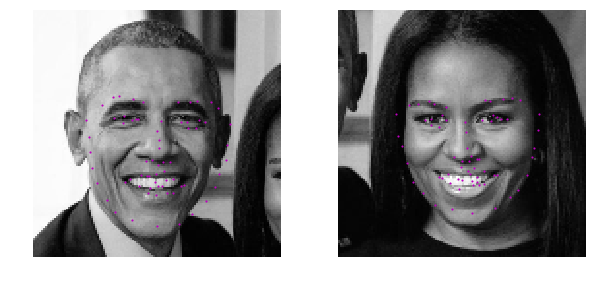

torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])


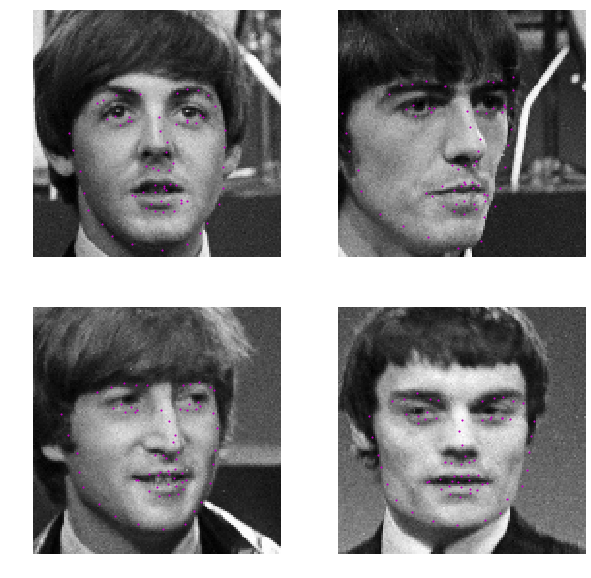

torch.Size([68, 2])


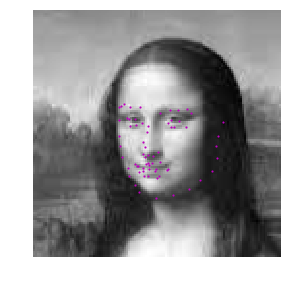

In [110]:
detect_keypoints(0,50)
detect_keypoints(2,50)
detect_keypoints(1,30)